In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# Define the path to your ZIP file in Google Drive
zip_file_path = '/content/drive/My Drive/dataset.zip'

# Check if the file is a valid zip file
if zipfile.is_zipfile(zip_file_path):
    # Create a destination directory for extracting the files
    destination_dir = '/content/dataset'
    os.makedirs(destination_dir, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)

    # List the extracted files
    extracted_files = os.listdir(destination_dir)
    print(f'Extracted files: {extracted_files}')
else:
    print(f'{zip_file_path} is not a valid zip file.')


Extracted files: ['dataset']


In [3]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-26 15:47:28--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   121MB/s    in 0.7s    

2024-06-26 15:47:29 (121 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [5]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [6]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (6, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [9]:
# Set the training parameters
import tensorflow as tf
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [10]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define our example directories and files
base_dir = '/content/dataset/dataset'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'val')

# Directory with train pictures
train_battery_dir = os.path.join(train_dir, 'battery')
train_glass_dir = os.path.join(train_dir, 'glass')
train_metal_dir = os.path.join(train_dir, 'metal')
train_organic_dir = os.path.join(train_dir, 'organic')
train_paper_dir = os.path.join(train_dir, 'paper')
train_plastic_dir = os.path.join(train_dir, 'plastic')


# Directory with validation pictures
validation_battery_dir = os.path.join(validation_dir, 'battery')
validation_glass_dir = os.path.join(validation_dir, 'glass')
validation_metal_dir = os.path.join(validation_dir, 'metal')
validation_organic_dir = os.path.join(validation_dir, 'organic')
validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_plastic_dir = os.path.join(validation_dir, 'plastic')


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 4200 images belonging to 6 classes.
Found 450 images belonging to 6 classes.


In [13]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 210,
            epochs = 20,
            validation_steps = 23,
            verbose = 2)

Epoch 1/20
210/210 - 29s - loss: 0.2459 - accuracy: 0.9155 - val_loss: 0.2980 - val_accuracy: 0.9267 - 29s/epoch - 136ms/step
Epoch 2/20
210/210 - 28s - loss: 0.2589 - accuracy: 0.9090 - val_loss: 0.2145 - val_accuracy: 0.9222 - 28s/epoch - 135ms/step
Epoch 3/20
210/210 - 28s - loss: 0.2604 - accuracy: 0.9117 - val_loss: 0.2687 - val_accuracy: 0.9200 - 28s/epoch - 135ms/step
Epoch 4/20
210/210 - 29s - loss: 0.2488 - accuracy: 0.9114 - val_loss: 0.3432 - val_accuracy: 0.9044 - 29s/epoch - 136ms/step
Epoch 5/20
210/210 - 30s - loss: 0.2314 - accuracy: 0.9169 - val_loss: 0.3459 - val_accuracy: 0.8911 - 30s/epoch - 141ms/step
Epoch 6/20
210/210 - 29s - loss: 0.2083 - accuracy: 0.9333 - val_loss: 0.3090 - val_accuracy: 0.9178 - 29s/epoch - 136ms/step
Epoch 7/20
210/210 - 28s - loss: 0.2481 - accuracy: 0.9117 - val_loss: 0.4296 - val_accuracy: 0.9178 - 28s/epoch - 136ms/step
Epoch 8/20
210/210 - 29s - loss: 0.2202 - accuracy: 0.9181 - val_loss: 0.2902 - val_accuracy: 0.9000 - 29s/epoch - 137

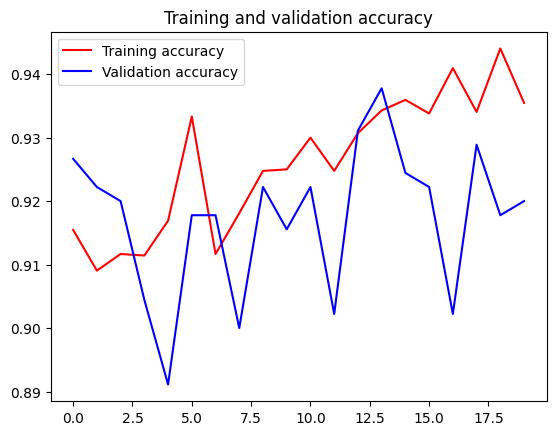

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [22]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))

    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    # Predict probabilities for each class
    classes = model.predict(x, batch_size=10)

    # Get the predicted class index
    predicted_class_index = np.argmax(classes, axis=-1)[0]

    # Map index to class label (adjust based on your dataset)
    if predicted_class_index == 0:
        predicted_class = 'battery'
    elif predicted_class_index == 1:
        predicted_class = 'glass'
    elif predicted_class_index == 2:
        predicted_class = 'metal'
    elif predicted_class_index == 3:
        predicted_class = 'organic'
    elif predicted_class_index == 4:
        predicted_class = 'paper'
    elif predicted_class_index == 5:
        predicted_class = 'plastic'
    else:
        predicted_class = 'unknown'

    # Print the predicted class and probability
    print(fn + " is predicted as " + predicted_class + " with probability " + str(classes[0][predicted_class_index]))


Saving glass.jpg to glass.jpg
1/1 [==============================] - 0s 25ms/step
glass.jpg is predicted as glass with probability 0.99999785
